# Generating Data Distributions 

<hr style="border:2px solid gray">

# Index: <a id='index'></a>

0. [Introduction to the Monte Carlo Method](#intro)
1. [Inverse Transform Sampling](#inverse)
1. [Numerical Inverse Transform](#numerical)
3. [The Accept-Reject Method](#accept-reject)
5. [Inbuilt Functions](#IF)
7. [Generating Correlated Variables - Cholesky Distribution](#cholesky)

<hr style="border:2px solid gray">

# Introduction to the Monte Carlo Method [^](#index) <a id='intro'></a>

Often you will need to simulate data distributions from experiments or theories to then compare with real data. This is called the **Monte Carlo method** and is a form of integration. The Monte Carlo method is often used for functions that are difficult to integrate or invert. However, to start with, we will discuss a more well behaved example and different methods will be explained below. 

<hr style="border:2px solid gray">

# Inverse Transform Sampling [^](#index) <a id='inverse'></a>

**Inverse transform sampling** is a basic method for generating random numbers according to a **probability distribution function** (pdf) given its **cumulative distribution function** (cdf). The mathematics given below show the fundamental ideas behind sampling the desired random distribution, however, the exact method is only applicable for integrable, invertable functions.

Let's say we want to generate a distribution of the random variable, $x$, such that it has a given pdf, $f(x)$, in the range $-\infty \le x \le \infty$. We can calculate the cdf up to a point $a$ with $f(x)$ by:

\begin{equation}    
    F(a) =  \int_{-\infty}^a f(x) dx .
\end{equation}  

Therefore, $F(a)$ is itself a random variable and has uniform probability. By inverting this relation, you can generate your desired distribution, i.e. from:

$u=F(x)$

follows:

$x=F^{-1}(u)$.

(*Note:* Random variables with uniform probability are often denoted by $u$, which has been used here as well.)

This becomes much easier to understand through a concrete example. Let's say we want to generate a distribution that has a pdf of $x^2$ for $ -2 \le x \le 2$. We can then write the cumulative distribution function, $F(x\prime )$, according to:

$u=F(x \prime ) = \int_{-2}^{x\prime } x^2 dx = \left[ \dfrac{x^3}{3} \right]_{-2}^{x\prime }$

This will be a uniform distribution between $-\dfrac{8}{3} \le u \le \dfrac{8}{3}$. Hence, if it is possible to invert the above relation, such as in this case, we can generate a uniform random number in that range and use the inverted function to get the desired pdf, i.e.:

$x = F^{-1}(u)= \sqrt[3]{3u}$ between $-\dfrac{8}{3} \le u \le \dfrac{8}{3}$

Let's see what this looks like as code:

In [2]:
import numpy as np
import pylab as pl
import numpy.random as npr 
import scipy.interpolate as spi

1.9999996576641585 -1.9999989060914451


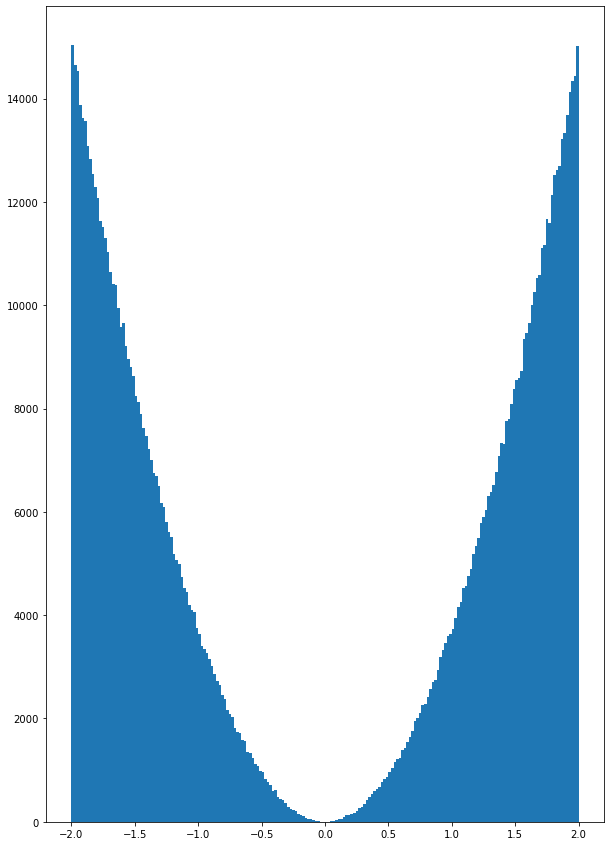

In [73]:
def inv(u):
    #calculate the cubic root of 3u
    return np.cbrt(3*u)

x=[]

#this is the amount of random numbers we will generate
nr=1000000

for i in range(nr):
    #let's generate u according to a uniform distribution
    u=npr.uniform(low=-8./3., high=8./3.) 
    #and calculate x = inv(u)
    x.append(inv(u))
    

x=np.array(x)
print(x.max(), x.min())
pl.hist(x,bins=200)

pl.show()
    

<div style="background-color: #FFF8C6">

### Optional Exercises


The code above could be much more efficient. How would you improve it? Try different approaches.

<hr style="border:2px solid gray">

# Numerical Inverse Transform [^](#index) <a id='numerical'></a>


The function that you have may be difficult to either integrate or invert. Howevever, provided you can calculate the function numerically, you can also integrate it numerically by summing the entries in the numpy array. This is done by setting the integral (i.e. sum) equal to 1, and then sampling between 0 and 1. We then need to interpolate between the steps in the integration, either linearly or with a cubic spline.

Once again, we will use a pdf of $x^2$ as our example:

1.0


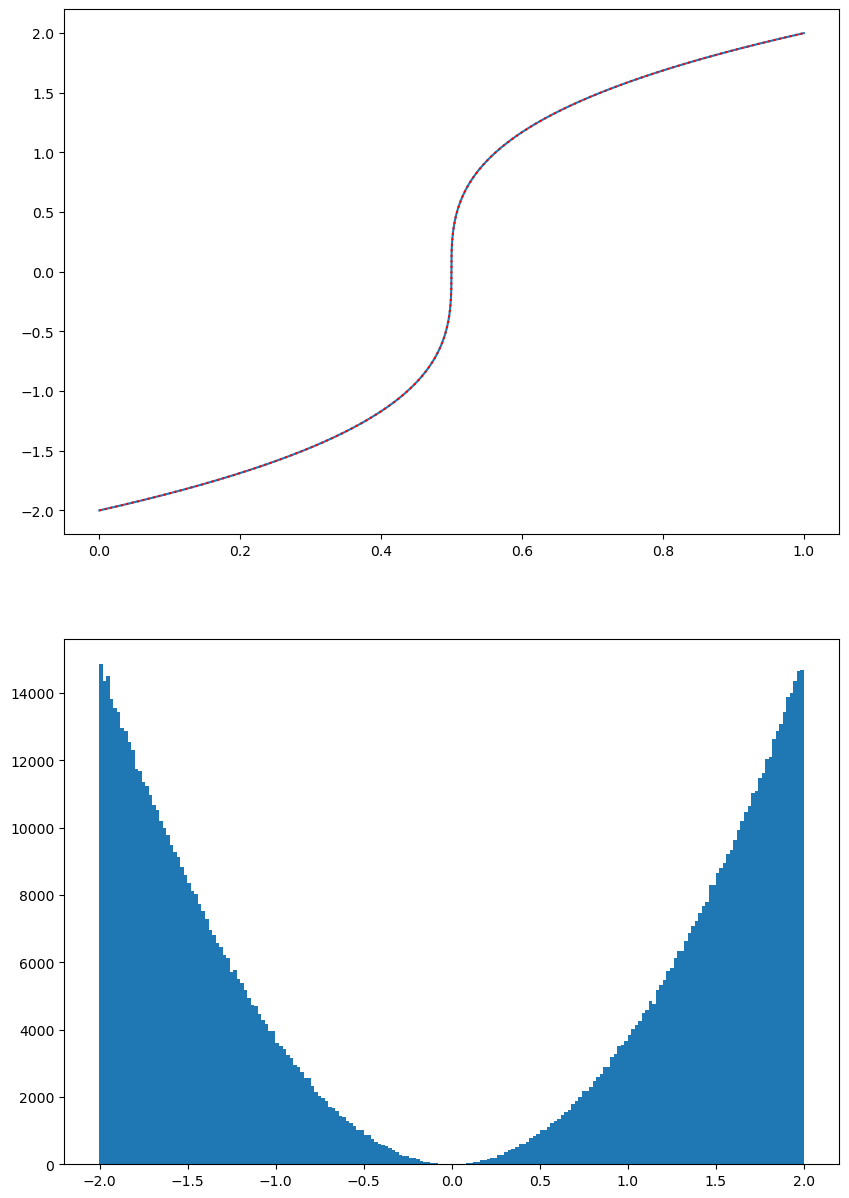

In [2]:
pl.rcParams['figure.figsize'] = [10, 15] 

x=np.arange(-2,2,0.0011) 
# step deliberately chosen so as to not exactly hit 0 
# splines don't like no change so avoid exactly zero

xsq=x*x
y=xsq.cumsum()

y=y/y[-1] #normalising the cumulative sum

print(y[-1])

# Now if we choose a value of x between 0 and 1, we can map it to a value between -2 and 2
# we will need to interpolate - one way of doing this is with a cubic spline


f = spi.CubicSpline(y,x) 
# This version allows f to be valid outside of the spline - which is useful here
# f is our approximation of the integral

# check if the spline is any good
pl.subplot(2,1,1)
pl.plot(y,x)
pl.plot(y,f(y),"r:")

# now generate the uniform random numbers and calculate x²
yr=npr.uniform(size=1000000)
xr=f(yr)

pl.subplot(2,1,2)
pl.hist(xr,bins=200)

pl.show()

<hr style="border:2px solid gray">

# The Accept-Reject Method [^](#index) <a id='accept-reject'></a>

If the pdf, $f(x)$, is even too complicated to invert numerically, then we can still use the accept-reject method.

First, we generate a random number, $x$, from a uniform distribution in our desired range, in this case $-2 \le x \le 2$, before generating a second random number, $y$, from the uniform distribution $h(y)$. The code below will display a graph of both these distributions (but you can ignore the code this time).

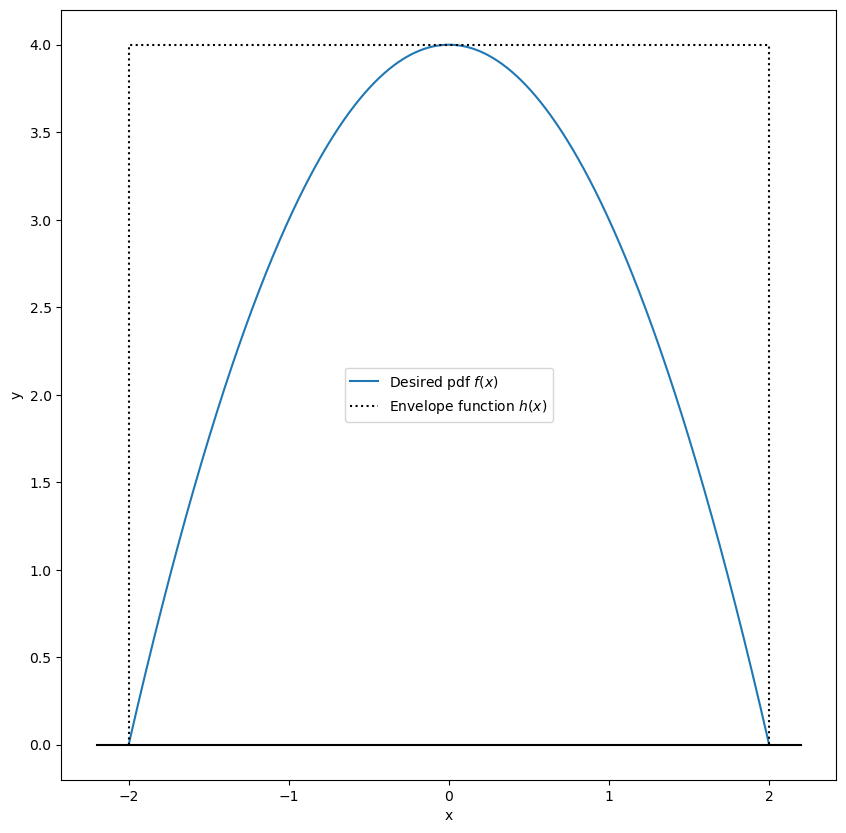

In [3]:
pl.rcParams['figure.figsize'] = [10, 10] 

def f(x): # the pdf that you want to generate
    return -x**2+4 # note only valid between +/- 2 as otherwise would be negative

x=np.arange(-2,2,0.001)
y=f(x)

pl.plot(x,y,label="Desired pdf $f(x)$")
pl.plot([-2.2,2.2],[0,0], "k")
pl.plot([-2,-2,2,2],[0,4,4,0],"k:",label="Envelope function $h(x)$")
pl.xlabel("x")
pl.ylabel("y")
pl.legend()
pl.show()

In order to get our target distribution from these two random uniform distributions, we compare $h(y)$ with $f(x)$. If $h(y) \le f(x)$, then we keep point $x$; otherwise it is rejected.

This can be visualised as follows: You randomly generate $x$ and $y$ values according to uniform distributions, hence the ($x$,$y$) samples fill the envelope function shown above. From all these generated samples, only those are kept that fall within the desired pdf, i.e. where the point ($x$,$y$) lies within the $f(x)$ curve. Therefore, the resulting density of accepted $x$ is the pdf $f(x)$, as is illustrated in the code example and histogram below.

***However,*** this means that this approach is very inefficient and should only be used when there really is no alternative.

*Note:* Many textbooks will tell you to normalise $f(x)$ and $h(y)$. However this is not needed if the numbers are scaled appropriately.

The following code shows how to implement this method in practice:

Only a fraction of 0.666667  are kept


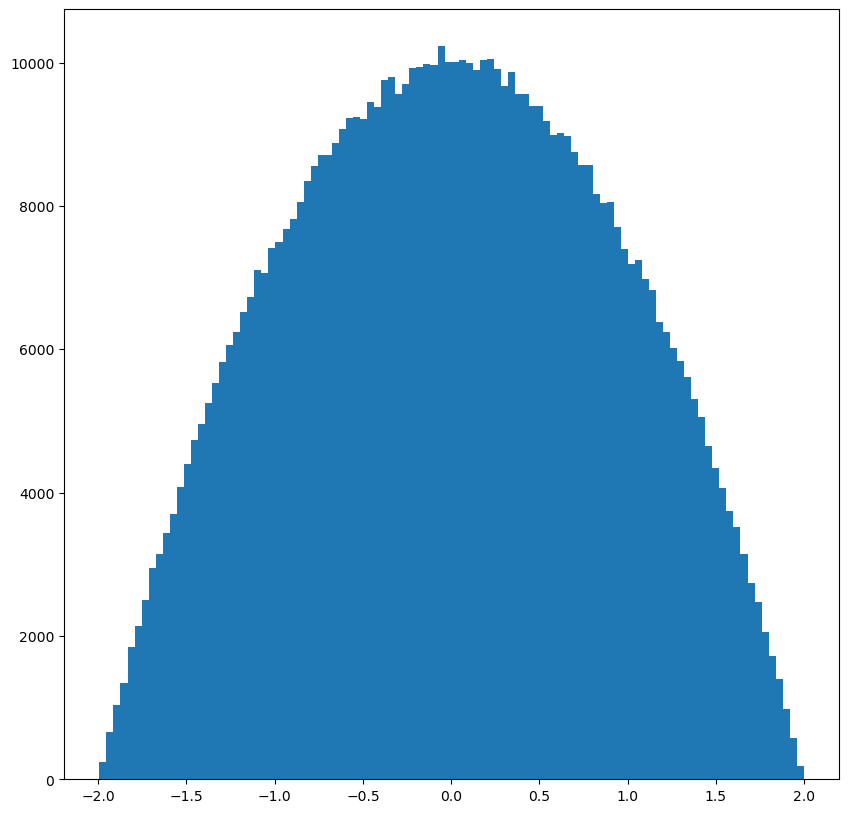

In [4]:
pl.rcParams['figure.figsize'] = [10, 10] 

def f(x): # the pdf that you want to generate
    return -x**2+4 # note only valid between +/- 2 as otherwise would be negative

icount=0 # just to count the number accepted
ntries=1000000 #setting the number of tries

xpdf=[]

for i in range(ntries):
    x=npr.uniform(low=-2,high=2)
    y=npr.uniform(low=0,high=4)
    if f(x) >= y: # if this is the case then keep the point
        xpdf.append(x)
        icount=icount+1

print("Only a fraction of",icount/ntries," is kept") 
        
pl.hist(xpdf,bins=100)
        
pl.show()      

<div style="background-color:#C2F5DD">

### Exercise 

Generate a distribution of 1 million entries with a pdf of $\sin(x)$ between 0 and $\pi$. Do this by:

1. Inverting the analytic integral;
1. Integrating numerically;
1. Using the accept-reject method.

In [ ]:
#Write code here

<hr style="border:2px solid gray">

# Inbuilt functions [^](#index) <a id='IF'></a>

Fortunately, there are random number generators that will generate random numbers according to many of the different pdfs that you are likely to need. These exist in both [numpy.random](https://numpy.org/doc/1.16/reference/routines.random.html) and [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) and are very efficiently tuned generators. Therefore, you should use them whenever possible.

<div style="background-color:#C2F5DD">

### Exercise 

Pick three functions from each of numpy.random and scipy.stats and generate different distributions. Try generating them with different sizes and shapes and plotting them, working out the covariance matrix between them etc. It is best if you pick distributions where you know what the expected distributions look like. This exercise is a little open ended, but that is deliberate.

<hr style="border:2px solid gray">

# Generating Correlated Variables - Cholesky Decomposition [^](#index) <a id='cholesky'></a>

Some of the generators will be able to generate **correlated random numbers** (for example, see [numpy](numpy.random.multivariate_normal) documentation), however it is important that you understand how to do this yourself. 

There are several ways of doing this and one of the most popular is Cholesky decomposition. 

### Mathematical Foundation of the Cholesky Decomposition

The covariance matrix, $\Sigma$, can be expressed as the product of two triangular matrices. If we take the lower triangular matrix $L$, we can write $\Sigma=LL^T$, where $L^T$ is the transpose of $L$. If we have a matrix containing uncorrelated variables and multiply it by $L$, the variables will then have the covariance described in $\Sigma$.

Therefore, mathematically, let
$
\begin{equation}
M = \begin{pmatrix}  \mathbf{x^T} \\ \mathbf{y^T} \end{pmatrix} = \begin{pmatrix} x_0 & x_1 & x_2 & ... & x_N \\ y_0 & y_1 & y_2 & ... & y_N \end{pmatrix}
\end{equation}
$

be the matrix containing $\mathbf{x}$ and $\mathbf{y}$ which are the vectors of our uncorrelated random variables. Then we can find $M \prime$:

\begin{equation}
M\prime = \begin{pmatrix}  \mathbf{x\prime ^T} \\ \mathbf{y \prime ^T} \end{pmatrix} = LM
\end{equation}

where $\mathbf{x\prime}$ and $\mathbf{y\prime}$ are now correlated variables with a covariance of $\Sigma$.

Consider the following practical example of this:

the lower triangular matrix
[[1.41421356 0.        ]
 [1.20208153 0.74498322]]
The product with the transpose
[[2.  1.7]
 [1.7 2. ]]
The measured covariance matrix is
[[2.00421461 1.7049117 ]
 [1.7049117  2.00581566]]


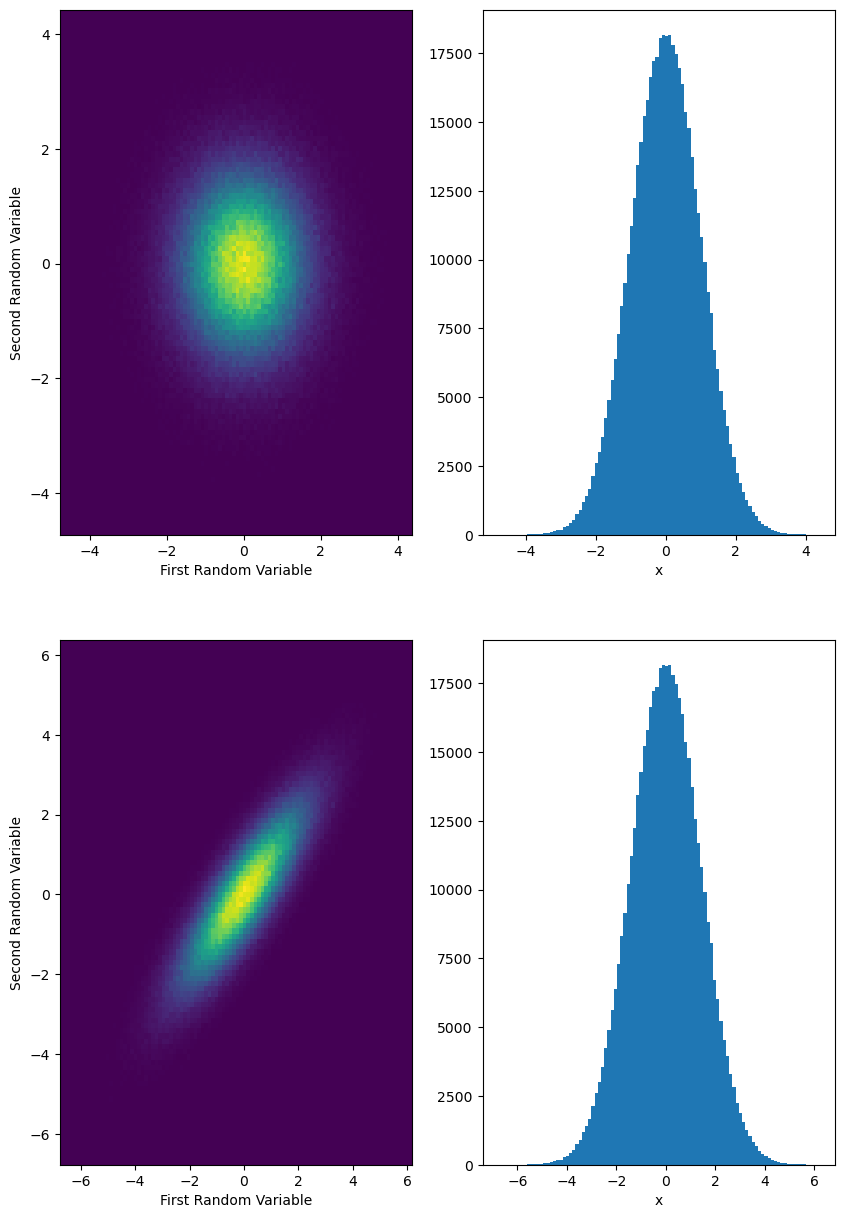

In [6]:
import scipy.linalg as spl

pl.rcParams['figure.figsize'] = [10, 15] 


# Define the covariance matrix  
# We will use Gaussians units so that this is the same as the correlation matrix
Sig=np.array([[2, 1.7],
             [1.7,2]])

L = spl.cholesky(Sig, lower=True)

print("the lower triangular matrix")
print(L)
print("The product with the transpose")
print(np.dot(L,L.T))

#xuncor=npr.exponential(5, size=(2, 500000))
xuncor=npr.normal(0, 1, size=(2, 500000))

x=xuncor[0]
y=xuncor[1]

pl.subplot(2,2,1)
pl.hist2d(x,y,bins=100)
pl.xlabel("First Random Variable" )
pl.ylabel("Second Random Variable")
          
# just plot a histogram of one variable
pl.subplot(2,2,2)
pl.hist(x,bins=100)
pl.xlabel("x")


xcorr=np.matmul(L,xuncor)
x=xcorr[0]
y=xcorr[1]

pl.subplot(2,2,3)
pl.hist2d(x,y,bins=100)
pl.xlabel("First Random Variable" )
pl.ylabel("Second Random Variable" )
pl.subplot(2,2,4)
pl.hist(x,bins=100)
pl.xlabel("x")

print("The measured covariance matrix is")
print(np.cov(xcorr))

pl.show()


<div style="background-color:#C2F5DD">

### Exercise

Since we are using Gaussians, the individual distributions have kept their shape.  Try using different distributions to investigate what happens when you apply a correlation.
